# Kaggle Competition: Bike Sharing Demand

## Agni Delvinioti

## Table of contents

1. [Dataset](#Dataset)

2. [Variables](#Variables)

3. [Problem Statement](#Problem-Statement)

4. [Step 1: Initialization](#Step-1:-Initialization)

5. [Step 2: Data pre-Processing](#Step-2:-Data-pre-Processing)

6. [Step 3: Exploratory Analysis](#Step-3:-Exploratory-Analysis)
    - [Feature Indepedence](#Feature-Independence)
    - [Visualization in year level](#Visualization-in-year-level)
    - [Visualization in month level](#Visualization-in-month-level)

7. [Step 4: Feature Selection](#Step-4:-Feature-Selection)

8. [Step 5: Logistic Regression with scikit-learn](#Step-5:-Logistic-Regression-with-scikit-learn)
    - [Random Model Formulation](#Random-Model-Formulation)
    - [Problem Specific Model Formulation](#Problem-Specific-Model-Formulation)

11. [Conclusions](#Conclusions)

## Dataset

[[ go back to the top ]](#Table-of-contents)

The dataset includes hourly rental data spanning two years (2011-2012). The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 
The dataset contains 10886 observations of 12 variables in provided [train data](./data/train.csv/) and 6493 observations of 9 variables in provided [test data](./data/test.csv/).

## Variables

[[ go back to the top ]](#Table-of-contents)

Complete list of given variables:

* **datetime**:  hourly date + timestamp  
* **season**:  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* **holiday**:  whether the day is considered a holiday
* **workingday**:  whether the day is neither a weekend nor holiday
* **weather**:  1:Clear, Few clouds, Partly cloudy, Partly cloudy, 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **temp**:  temperature in Celsius
* **atemp**:  "feels like" temperature in Celsius
* **humidity**:  relative humidity
* **windspeed**:  wind speed
* **casual**:  number of non-registered user rentals initiated
* **registered**:  number of registered user rentals initiated
* **count**:  number of total rentals

## Problem Statement

[[ go back to the top ]](#Table-of-contents)

The objective of Bike Sharing Demand-Kaggle competition is to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. In this project, we allow the exploratory analysis of the data to direct us to a probably more convenient problem definition.

## Step 1:  Initialization

[[ go back to the top ]](#Table-of-contents)

We start our analysis by importing all necessary python modules for our approach, namely computational, statistical, visualization and machine learning tools.

### Import Modules

In [3]:
import pandas as pd
import sklearn as sk
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from scipy.stats.stats import pearsonr  
import math

### Configure Plot Environment

In [4]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

## Step 2: Data pre-Processing

[[ go back to the top ]](#Table-of-contents)

After simply reading the training and testing files, we parse the date information and format the temperature feature for convenience.

In [5]:
# read train data
train = pd.read_csv("./data/train.csv", parse_dates=["datetime"])

# number of observations in train data
print(train.shape)

# parse date
train["hour"] = pd.DatetimeIndex(train['datetime']).hour
train["month"] = pd.DatetimeIndex(train['datetime']).month
train["day"] = pd.DatetimeIndex(train['datetime']).day
#train["year"] = pd.DatetimeIndex(train['datetime']).year

# convert celcious--->faraday
train["temp"] =  train.temp*9.0/5.0+32.0
train["atemp"] = train.atemp*9.0/5.0+32.0

# repeat for test data
test = pd.read_csv("./data/test.csv", parse_dates=["datetime"])

# number of observations in test data 
print(test.shape)
test["hour"] = pd.DatetimeIndex(test['datetime']).hour
test["month"] = pd.DatetimeIndex(test['datetime']).month
test["day"] = pd.DatetimeIndex(test['datetime']).day
#test["year"] = pd.DatetimeIndex(test['datetime']).year
test["temp"] =  test.temp*9.0/5.0+32.0
test["atemp"] = test.atemp*9.0/5.0+32.0

(10886, 12)
(6493, 9)


## Step 3: Exploratory Analysis

### Feature Independence

[[ go back to the top ]](#Table-of-contents)

As a primary step, we aim to discover any possible hidden correlation between the input variables/features. Such a strategy can assist to make the problem 'better' defined and thus efficiently solvable.
Note some intuition: 

- the observations are 'naturally' dependent as **time series** 
- there are 3 levels of **periodicity**: year, season, month
- provided we want to make hourly predictions **month level** 'might be' more informative
- **holiday** feature is redundant since captured by the complement of **workingday** (workingday = 0)
- **temp** feature is strongly related to **atemp**

                hour     month      temp     atemp  humidity  windspeed  \
hour        1.000000 -0.006818  0.145430  0.140343 -0.278011   0.146631   
month      -0.006818  1.000000  0.257589  0.264173  0.204537  -0.150192   
temp        0.145430  0.257589  1.000000  0.984948 -0.064949  -0.017852   
atemp       0.140343  0.264173  0.984948  1.000000 -0.043536  -0.057473   
humidity   -0.278011  0.204537 -0.064949 -0.043536  1.000000  -0.318607   
windspeed   0.146631 -0.150192 -0.017852 -0.057473 -0.318607   1.000000   
count       0.400601  0.166862  0.394454  0.389784 -0.317371   0.101369   
registered  0.380540  0.169451  0.318571  0.314635 -0.265458   0.091052   
casual      0.302045  0.092722  0.467097  0.462067 -0.348187   0.092276   

               count  registered    casual  
hour        0.400601    0.380540  0.302045  
month       0.166862    0.169451  0.092722  
temp        0.394454    0.318571  0.467097  
atemp       0.389784    0.314635  0.462067  
humidity   -0.317371   -

<matplotlib.colorbar.Colorbar instance at 0x7f8ebd1f9a70>

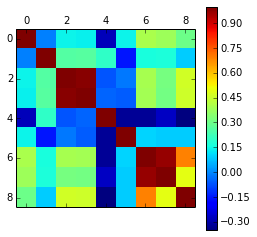

In [6]:
# choose features from data
feature_cols = ['hour', 'month', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'registered', 'casual']
trainSelection = train[feature_cols]

#compute cross-correlation coefficients
print(trainSelection.corr())
plt.figure()

#confusion matrix
plt.matshow(trainSelection.corr())
plt.colorbar()

The confusion matrix indicates dependency for the following feature pairs:

- temp-atemp 
- count-registered 

In [7]:
# compute pearson correlation for highly correlated features
# temp-atemp
corrTAT = pearsonr(train.temp, train.atemp)
print(corrTAT)

# count-registered
corrCR = pearsonr(train["count"], train["registered"])
print(corrCR)

(0.98494811048172715, 0.0)
(0.97094810580983315, 0.0)


### Visualization in year level

[[ go back to the top ]](#Table-of-contents)

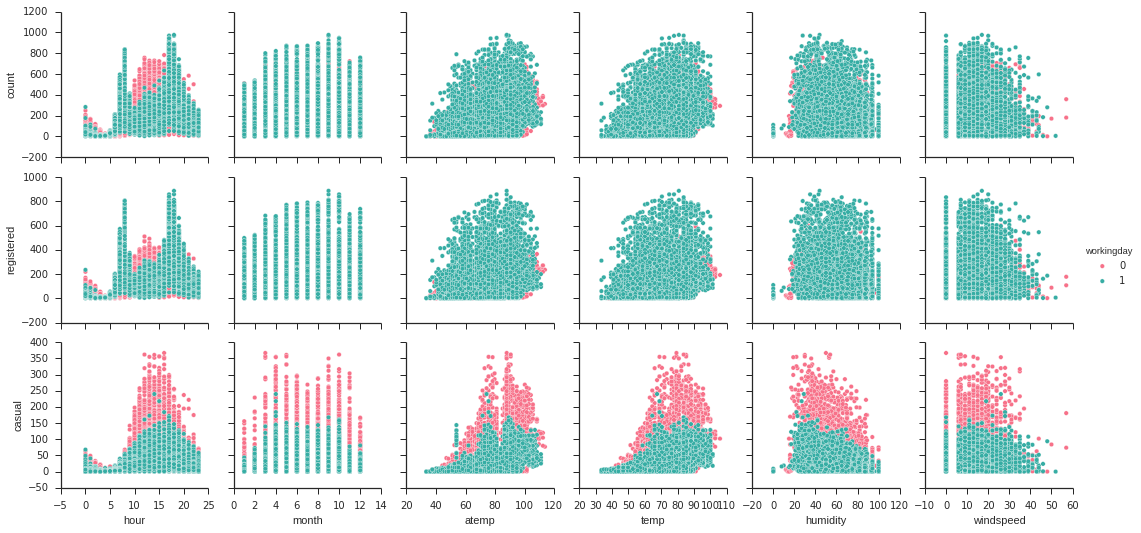

In [8]:
# general visualization
import seaborn as sb; 
sb.set(style="ticks", color_codes=True)
sb_plot = sb.pairplot(train, hue="workingday", palette="husl",x_vars=['hour', 'month', 'atemp', 'temp', 'humidity', 'windspeed'], y_vars=["count", "registered","casual"])

The scatter plots above show similar behavior of count and registered output variables over all other features, while casual variable diverges significantly both quantitatively and qualitatively.

Additionallly, we observe different trends for working and non-working days. The previous can be easily validated by the casual variable analysis and also hour variable across all demand categories (count, registered, casual).

### Visualization in month level

[[ go back to the top ]](#Table-of-contents)

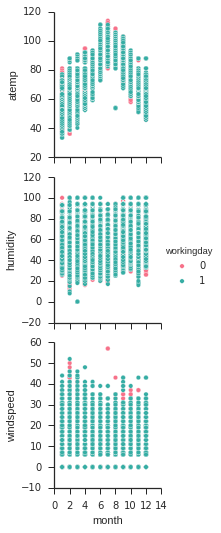

In [9]:
# visualization in month level
sb_plot = sb.pairplot(train, hue="workingday", palette="husl",y_vars=['atemp', 'humidity', 'windspeed'], x_vars=["month"])

From the above monthly analysis, it follows that feature set (atemp, humidity, windspeed) formulate distributions with significant variance to 'explain'/'infer' the output variable demand.

## Step 4: Feature Selection

[[ go back to the top ]](#Table-of-contents)

In this section we apply a decision tree classifier to estimate the importance of the input variables and support the conclusions of the data exploration.

In [10]:
# change colormaps
from matplotlib.colors import LinearSegmentedColormap

In [11]:
# define train and test tests
trainFS= train.ix[(train.day <19),] 
testFS = train.ix[(train.day >=19),]

# feature selection
feature_cols = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour']
X_train = trainFS[feature_cols]
y_train = trainFS["count"]
X_test = testFS[feature_cols]

For the traning procedure of the feature selector, we keep the temporal order of the data (no random split). Morevover, we set as validation set the last observation of every month in the training set, the 19th in a similar fashion with the final problem.

In [12]:
#apply decision tree classifier
from sklearn.ensemble import ExtraTreesClassifier
params = {'n_estimators': 50, 'random_state': np.random.RandomState(1)}

clf = ExtraTreesClassifier(**params)

In [ ]:
# fit train set to model
clf.fit(X_train, y_train)

#  running issue! too heavy for server-manual run in kaggle server

In [2]:
# predict test set and evaluate
y_pred = clf.predict(X_test)
print('\nCorrelation coefficients:\n')
print(np.corrcoef(y_pred, y_test))

print('\nFeature importances:\n')
print(clf.feature_importances_ )

# running issue! too heavy for server-manual run in kaggle server

NameError: name 'clf' is not defined

In the following, the run time results are copied from Kaggle competition's server because of computational overload on jupyter. The parameter n_estimators is set in a high enough number to ensure better interpration of the features.

In [15]:
# running issue! too heavy for server-manual run in kaggle server
#feature_importance = clf.feature_importances_  ----> instead for now
feature_importance  = np.array([ 0.03710819,  0.00650949,  0.01282767,  0.04413451,  0.1420116,   0.14521796,
  0.20125632,  0.21236422,  0.19857004])

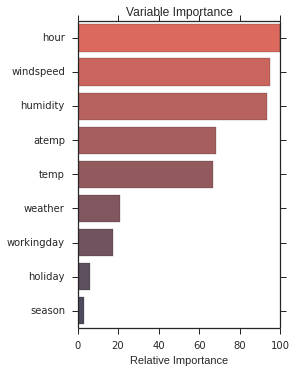

In [18]:
# plot feature importance
sorted_idx = np.argsort(feature_importance)

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)

# set color transparency (0: transparent; 1 solid)
a = 0.7

# create a colormap
customcmap = [(x/10.0,  x/50.0, 0.1) for x in range(len(feature_importance))]
plt.barh(pos, feature_importance[sorted_idx], align='center',  alpha=a, color=customcmap)
plt.yticks(pos, feature_cols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The feature importance feature proves the previous observation about features indepencency and leads to the decision of sticking only to top 4 features for our approach, namely (hour, windspeed, humidity, atemp).

## Step 5: Logistic Regression with scikit-learn

In this section we try 2 different model formulations to stress out the significance of:

- problem specific design
- right model selection

We choose logistic regression with scikit-learn for the following reasons:

- it can be easily adjusted to the task of interest with direct insights over the variables involved
- it is simple and state-of-the-art in regression tasks 
- scikit-learn is a rich in methods/documentation and systematic toolbox

Both schemes are designed to solve the per month classification problem involving two classes: $(1) (trainday <15),  (2)  (trainday >=15)$. Additionally, a Grid Search over regularization parameter C is always employed for higher accuracy.

Several evaluation metrics are used to clarify as much as possible every scheme.

### Random Model Design

[[ go back to the top ]](#Table-of-contents)

In the following setting we first normalize all features and then allow the learner to decide a regularization scheme, adding no prior information about which features are more informative or interpretable. On the contrary, we rather prefer to deal with them agnostically.

In [20]:
# logistic regression model for count output variable
print('\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
print('\n(1) Optimized Logistic Regression model-random:\n')

# initialize
error_train = np.zeros(12)
error_test = np.zeros(12)

# feature selection
feature_cols = ['atemp', 'humidity', 'windspeed', 'hour']

# iterrate
for month_id in range(1, 13):
    print('\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
    print('\nmonth: '+ repr(month_id)+'\n')
    
    # read data/split to train and test set
    train_month = train.ix[(train.month == month_id) & (train.day <15),]  
    test_month = train.ix[(train.month == month_id)  & (train.day >=15),] 
    
    # prepare X,y
    X_train = train_month[feature_cols]
    y_train = np.round(np.log10(train_month["count"]+1)) 
    X_test = test_month[feature_cols]
    y_test =  np.round(np.log10(test_month["count"]+1)) 
    
    # load libraries
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn import grid_search
    
    # normalize features
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
   
    # fit model
    clf = LogisticRegression()
    
    # optimize parameter C
    parameters = {'C':[1, 100]}
    clf_LR = grid_search.GridSearchCV(clf, parameters)
    clf_LR.fit(X_train, y_train)
    
    # predict
    y_pred_train = clf_LR.predict(X_train)
    y_pred_test = clf_LR.predict(X_test)
    
    # generate evaluation metrics
    print("\n*accuracy score for train set:\n")
    print metrics.accuracy_score(y_train, y_pred_train)  
    print("\n*confusion matrix for test set:\n")
    print metrics.confusion_matrix(y_test, y_pred_test)
    print("\n*classification report for test set:\n")
    print metrics.classification_report(y_test, y_pred_test)
    
    # results
    print('\n*Root Mean Squared Logarithmic Error (RMSLE) on test set:\n')
    error_train[month_id-1] = math.sqrt(((y_train-y_pred_train)**2).mean())
    print '%.3f' % (error_train[month_id-1])
    
    print('\n*Root Mean Squared Logarithmic Error (RMSLE) on test set:\n')
    error_test[month_id-1] = math.sqrt(((y_test-y_pred_test)**2).mean())
    print '%.3f' % (error_test[month_id-1])
    
print('\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
print('\n*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-\n')
print('\naverage RMSLE on train set:\n') 
print '%.3f' % (np.mean(error_train))

print('\naverage RMSLE on test set:\n') 
print '%.3f' % (np.mean(error_test))


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


(1) Optimized Logistic Regression model-random:


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


month: 1


*accuracy score for train set:

0.753799392097

*confusion matrix for test set:

[[  0   4   8   0]
 [  0  33  28   0]
 [  0  10 135   0]
 [  0   0   8   0]]

*classification report for test set:

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        12
        1.0       0.70      0.54      0.61        61
        2.0       0.75      0.93      0.83       145
        3.0       0.00      0.00      0.00         8

avg / total       0.67      0.74      0.70       226


*Root Mean Squared Logarithmic Error (RMSLE) on test set:

0.532

*Root Mean Squared Logarithmic Error (RMSLE) on test set:

0.602

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


month: 2


*accuracy score for train set:

0.793363499246

*confusio

### Problem Specific Model Design

[[ go back to the top ]](#Table-of-contents)

Different than previous section, we carefully design the learning formula and choose the type of features, both adding reasoning and considering the conclusions of the exploratory analysis and feature selection.

To prepare the data, we add an intercept column as well as dummy variables for input variable hour, since we consider itm as categorial variable. 

We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [21]:
# logistic regression model for count output variable 
print('\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
print('\n(2) Optimized Logistic Regression model-problem specific:\n')

# initialize
error_train = np.zeros(12)
error_test = np.zeros(12)

# iterrate
for month_id in range(1, 13):
    print('\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
    print('\nmonth: '+ repr(month_id)+'\n')
    
    # read data/split to train and test set
    train_month = train.ix[(train.month == month_id) & (train.day <15),]
    test_month = train.ix[(train.month == month_id)  & (train.day >=15),]    
    
    
    # import modules
    from patsy import dmatrices
    
    # create dataframes with an intercept column and dummy variables for hour variable and train data
    y_train, X_train = dmatrices('np.round(np.log10(count+1)) ~ atemp + humidity + windspeed + C(hour)',
                      train_month, return_type="dataframe")  

    # flatten y_train into a 1-D array
    y_train = np.ravel(y_train)
    
    # create dataframes with an intercept column and dummy variables for for hour variable and test data
    y_test, X_test = dmatrices('np.round(np.log10(count+1)) ~ atemp + humidity + windspeed + C(hour)',
                      test_month, return_type="dataframe")
    
    # flatten y_test into a 1-D array
    y_test = np.ravel(y_test)
    
    # instantiate a logistic regression model, and fit with X_train and y_train
    clf_LR = LogisticRegression()
    
    # optimize parameter C
    parameters = {'C':[1, 100]}
    clf_LR = grid_search.GridSearchCV(clf, parameters)
    clf_LR.fit(X_train, y_train)
    
    # check the accuracy on the training set
    clf_LR.score(X_train, y_train)
    
    # predict
    y_pred_train = clf_LR.predict(X_train)
    y_pred_test = clf_LR.predict(X_test)
    
    # generate evaluation metrics
    print("\n*accuracy score for train set:\n")
    print metrics.accuracy_score(y_train, y_pred_train)  
    print("\n*confusion matrix for test set:\n")
    print metrics.confusion_matrix(y_test, y_pred_test)
    print("\n*classification report for test set:\n")
    print metrics.classification_report(y_test, y_pred_test)
    
    # results
    print('\n*Root Mean Squared Logarithmic Error (RMSLE) on test set:\n')
    error_train[month_id-1] = math.sqrt(((y_train-y_pred_train)**2).mean())
    print '%.3f' % (error_train[month_id-1])
    
    print('\n*Root Mean Squared Logarithmic Error (RMSLE) on test set:\n')
    error_test[month_id-1] = math.sqrt(((y_test-y_pred_test)**2).mean())
    print '%.3f' % (error_test[month_id-1])
    
print('\n-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
print('\n*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-\n')
print('\naverage RMSLE on train set:\n') 
print '%.3f' % (np.mean(error_train))

print('\naverage RMSLE on test set:\n') 
print '%.3f' % (np.mean(error_test))



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


(2) Optimized Logistic Regression model-problem specific:


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


month: 1


*accuracy score for train set:

0.797872340426

*confusion matrix for test set:

[[  0  11   1   0]
 [  2  39  20   0]
 [  0   8 136   1]
 [  0   0   7   1]]

*classification report for test set:

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        12
        1.0       0.67      0.64      0.66        61
        2.0       0.83      0.94      0.88       145
        3.0       0.50      0.12      0.20         8

avg / total       0.73      0.78      0.75       226


*Root Mean Squared Logarithmic Error (RMSLE) on test set:

0.488

*Root Mean Squared Logarithmic Error (RMSLE) on test set:

0.484

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


month: 2


*accuracy score for train set:

0.808446455505


## Conclusions

Logistic Regression predicts the bike sharing demand with low error rates. Insights provided by data exploration for feature selection and careful model design impact significantly the efficiency of the predictor.

Many more methods and theories can apply, such as non linear models and regularization methods (kernels and gradient descend algorithm). An interesting problem still remains how the count variable is divided to casual and registered variables and in what way and how much the workingday variable is related to them.
An idea could be the design of 2 separate systems one for each flow and the combination of them (neural net approach maybe).